RoBERTa for Semantic Evaluation
USe of GPU capabilitiwes is strongly advised. https://developer.nvidia.com/cuda-downloads?target_os=Windows&target_arch=x86_64&target_version=10

Tested on Python 3.8.10

In [ ]:
from google.colab import drive
drive.mount("/content/drive/")



Mounted at /content/drive/


In [ ]:
import os
root = '/content/drive/My Drive/stud/nlp/isits_ft2/'
semeval2_root = '/content/drive/My Drive/stud/nlp/semeval2/'
semeval_root = '/content/drive/My Drive/stud/nlp/semeval/'


In [ ]:
astrain = pd.read_csv(semeval_root+'answers_students/answers_students_train_data.tsv', header= 0, sep='\t')
htrain = pd.read_csv(semeval_root+'headlines/headlines_train_data.tsv', header= 0, sep='\t')
imgtrain = pd.read_csv(semeval_root+'images/images_train_data.tsv', header= 0, sep='\t')

df_train = pd.concat([astrain, htrain, imgtrain], axis=0)
df_train.reset_index(inplace=True, drop=True)
df_train.to_csv( semeval2_root+'train.csv',index=False)

In [ ]:
astest = pd.read_csv(semeval_root+'answers_students/answers_students_test_data.tsv', header= 0, sep='\t')
htest = pd.read_csv(semeval_root+'headlines/headlines_test_data.tsv', header= 0, sep='\t')
imgtest = pd.read_csv(semeval_root+'images/images_test_data.tsv', header= 0, sep='\t')

df_test = pd.concat([astest, htest, imgtest], axis=0)
df_test.reset_index(inplace=True, drop=True)
df_test.to_csv( semeval2_root+'test.csv',index=False)

In [ ]:
astest = pd.read_csv(semeval_root+'answers_students/answers_students_test_data.tsv', header= 0, sep='\t')
htest = pd.read_csv(semeval_root+'headlines/headlines_test_data.tsv', header= 0, sep='\t')
imgtest = pd.read_csv(semeval_root+'images/images_test_data.tsv', header= 0, sep='\t')

In [ ]:
imgtest['y_score'].value_counts()

5    499
3    235
2    170
1     35
4      3
Name: y_score, dtype: int64

In [ ]:
!pip3 install transformers==4.25.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 51.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 29.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 110.3 MB/s eta 0:00:00


In [ ]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import torch
import seaborn as sns
import transformers
import pandas as pd
import seaborn as sns
import json
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
from transformers import RobertaModel, RobertaTokenizer
import logging
logging.basicConfig(level=logging.ERROR)
from ipywidgets import IntProgress
from transformers import RobertaTokenizer, RobertaModel, AdamW, get_linear_schedule_with_warmup
import time

In [ ]:
df_train['y_score'].value_counts()

5    2447
3     765
2     571
1     233
4      58
Name: y_score, dtype: int64

Proba ze zbiorem semieval2

In [ ]:
df_train = pd.read_csv(semeval2_root+'train.csv', header= 0)
df_test = pd.read_csv(semeval2_root+'test.csv', header= 0)


types_map = {'EQUI':0, 'SIMI':1, 'SPE1':2, 'SPE2':3, 'REL':4, 'OPPO':5}

def preprocess_semeval(semeval_df, is_score_based = False):
  #semeval_df['type'] = semeval_df['explanation'].map(types_map)


  semeval_df['text'] = semeval_df['x1'] + " . " + semeval_df['x2']

  #df = df.drop(['type'], axis=1)
  semeval_df['target1'] = semeval_df['y_score'] - 1
  semeval_df['target2'] = semeval_df['y_type'] - 1

  semeval_df = semeval_df.drop(['y_score'], axis=1)
  semeval_df = semeval_df.drop(['y_type'], axis=1)
  semeval_df = semeval_df.drop(['x1'], axis=1)
  semeval_df = semeval_df.drop(['x2'], axis=1)
  #semeval_df['target2'] = semeval_df['type']
  return semeval_df

df_train = preprocess_semeval(df_train, is_score_based=is_score_based)
df_test = preprocess_semeval(df_test, is_score_based=is_score_based)

In [ ]:
unique_values = df_train['x1'].unique()
len(unique_values)/len(df_train)

0.6659302896416298

In [ ]:
sorted_df_train = df_train.sort_values('x1', ascending = False)
sorted_df_test = df_test.sort_values('x1', ascending = False)

In [ ]:
# Zakładając, że 'df1' i 'df2' to dwie ramki danych

intersection = pd.merge(df_train, df_test, on=['x1','x2'], how='inner')

# Dostęp do powtarzających się komórek
#repeated_cells = intersection['chunk1', 'chunk2']

# Liczba powtarzających się komórek
intersection_count = len(intersection)

print("Liczba powtarzających się komórek: ", intersection_count)

Liczba powtarzających się komórek:  5435


In [ ]:
sorted_df_test

,x1,x2,text,target1,target2
805,z,A C Z and X,z . A C Z and X,2,1
2074,you,you,you . you,4,4
1958,you,you,you . you,4,4
345,x and z,A C Z and X,x and z . A C Z and X,2,1
2110,writing,busy,writing . busy,0,2
...,...,...,...,...,...
1912,056 pct,05 pct,056 pct . 05 pct,1,3
1438,02 pct,up 02 percent,02 pct . up 02 percent,2,3
482,0,in the same state,0 . in the same state,2,2
2113,'s head,'s head,'s head . 's head,4,4


In [ ]:
sorted_df_train

,chunk1,chunk2,value,explanation,type,text,target1,target2,targets12
674,zipping up,to slide up,3,SIMI,1,zipping up . to slide up,2,1,21
468,wounded,wounded,5,EQUI,0,wounded . wounded,4,0,40
503,wounded,wounded,5,EQUI,0,wounded . wounded,4,0,40
2252,would be,is,4,SIMI,1,would be . is,3,1,31
329,work,access,3,SPE1,2,work . access,2,2,22
...,...,...,...,...,...,...,...,...,...
736,$ 53m,$ 53 million worth,5,EQUI,0,$ 53m . $ 53 million worth,4,0,40
2600,"""the electrical state difference",different electrical states,4,SIMI,1,"""the electrical state difference . different e...",3,1,31
2480,"""the battery terminals",the battery,4,SPE1,2,"""the battery terminals . the battery",3,2,32
2059,"""bulb A""""s path switch Z""",Switch Y and bulb A in the same closed path,2,REL,4,"""bulb A""""s path switch Z"" . Switch Y and bulb ...",1,4,14


In [ ]:
df_train

,text,target1,target2
0,A battery to a bulb . the bulb and the battery,4,4
1,should connect . are,1,2
2,in a closed path . in a closed path,4,4
3,is connected . is connected,4,4
4,to the battery terminal . to the negative batt...,2,3
...,...,...,...
4069,at the camera . at the camera,4,4
4070,A small cat . The small dog,1,1
4071,look . looking,4,4
4072,at the camera . at the camera,4,4


In [ ]:
from sklearn.model_selection import train_test_split
#df = pd.concat([df_train_headlines, df_train_as, df_train_imgs])

df['targets12'] = df['target1'].astype(str) + df['target2'].astype(str)

df_train, df_valid = train_test_split(df, test_size=0.2, stratify = df[['targets12']])

df_train.drop('targets12', inplace = True, axis = 1)
df_valid.drop('targets12', inplace = True, axis = 1)

In [ ]:
df_test['target2'].value_counts()

4    1748
3     752
2     365
1     162
0      18
Name: target2, dtype: int64

In [ ]:
# Save preprocessed data
df_train.to_csv(root+"/ists_scores_training.csv")
df_valid.to_csv(root+"/ists_scores_test.csv")

In [ ]:
# Set random seed and set device to GPU.
torch.manual_seed(17)

if torch.cuda.is_available():
    device = torch.device('cuda:0')
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
else:
    device = torch.device('cpu')

print(device)

cuda:0


In [ ]:
# Initialize tokenizer.
tokenizer = RobertaTokenizer.from_pretrained("roberta-base")

In [ ]:
class Data(Dataset):
    def __init__(self, dataframe, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.data = dataframe
        self.text = dataframe.text
        self.target1 = self.data.target1
        self.target2 = self.data.target2
        self.max_len = max_len

        self.scores = torch.nn.functional.one_hot(torch.tensor(self.data.target1), num_classes=5).float()
        self.types = torch.nn.functional.one_hot(torch.tensor(self.data.target2), num_classes=len(types_map)).float()      


    def __len__(self):
        return len(self.text)

    def __getitem__(self, index):
        text = str(self.text[index])
        text = " ".join(text.split())

        inputs = self.tokenizer.encode_plus(
            text,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            pad_to_max_length=True,
            return_token_type_ids=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        token_type_ids = inputs["token_type_ids"]


        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
            'targets': (self.scores[index], self.types[index])
        }

In [ ]:
MAX_LEN = 256

train_data = df_train.reset_index(drop=True)
valid_data = df_valid.reset_index(drop=True)
test_data = df_test.reset_index(drop=True)

print("TRAIN Dataset: {}".format(train_data.shape))
print("VALID Dataset: {}".format(valid_data.shape))
print("TEST Dataset: {}".format(test_data.shape))

training_set = Data(train_data, tokenizer, MAX_LEN)
valid_set = Data(valid_data, tokenizer, MAX_LEN)
testing_set = Data(test_data, tokenizer, MAX_LEN)

TRAIN Dataset: (2352, 8)
VALID Dataset: (589, 8)
TEST Dataset: (3045, 3)


In [ ]:
class_value_counts1 = pd.DataFrame(train_data['target1']).value_counts(sort=False)
    # odwrotne wagowanie klas
weights1 = ((1/class_value_counts1.values) / np.sum(1/class_value_counts1.values ))
print(weights1)
class_weights1 = torch.FloatTensor(weights1).cuda()


class_value_counts2 = pd.DataFrame(train_data['target2']).value_counts(sort=False)
    # odwrotne wagowanie klas
weights2 = ((1/class_value_counts2.values) / np.sum(1/class_value_counts2.values ))
print(weights2)
class_weights2 = torch.FloatTensor(weights2).cuda()

class_weights = merged = torch.cat((class_weights1, class_weights2))

print(class_weights2)

[0.76480327 0.12048271 0.06765567 0.03462692 0.01243143]
[0.01491312 0.06365025 0.09921072 0.09148002 0.17464367 0.55610222]
tensor([0.0149, 0.0637, 0.0992, 0.0915, 0.1746, 0.5561], device='cuda:0')


In [ ]:
def save_metrics(path, train_loss_list, valid_loss_list, global_steps_list):   
    state_dict = {'train_loss_list': train_loss_list,
                  'valid_loss_list': valid_loss_list,
                  'global_steps_list': global_steps_list}
    torch.save(state_dict, path)
    

def load_metrics(path):    
    state_dict = torch.load(path, map_location=device)
    return state_dict['train_loss_list'], state_dict['valid_loss_list'], state_dict['global_steps_list']

In [ ]:
class RobertaClass(torch.nn.Module):
    def __init__(self, roberta_path = None, roberta_model = None):
        NUM_OUTPUTS = 11
        super(RobertaClass, self).__init__()
        if roberta_path:
          self.l1 = torch.load(roberta_path)
        if roberta_model:
          self.l1 = roberta_model
        else:
          self.l1 = RobertaModel.from_pretrained("roberta-base")

        self.pre_classifier = torch.nn.Linear(768, 768)
        self.dropout = torch.nn.Dropout(0.3)
        self.classifier = torch.nn.Linear(768, 5)

        self.pre_classifier2 = torch.nn.Linear(768, 768)
        self.dropout2 = torch.nn.Dropout(0.3)
        self.classifier2 = torch.nn.Linear(768, 6)

    def save_roberta(self, path):
        torch.save(self.l1, path)

    def save_model(self, path):
        torch.save(self, path)

    def forward(self, input_ids, attention_mask, token_type_ids):
        output_1 = self.l1(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
        hidden_state = output_1[0]
        x = hidden_state[:, 0]

        x1 = self.pre_classifier(x)
        x1 = torch.nn.ReLU()(x1)
        x1 = self.dropout(x1)
        output1 = self.classifier(x1)
        #output1 = F.softmax(output1, dim=1)  # Applying softmax

        x2 = self.pre_classifier2(x)
        x2 = torch.nn.ReLU()(x2)
        x2 = self.dropout2(x2)
        output2 = self.classifier2(x2)
        #output2 = F.softmax(output2, dim=1)  # Applying softmax


        return output1, output2

In [ ]:
def loss_fun(y_score, pred_score, y_type, pred_type):
  loss_fun1 = torch.nn.CrossEntropyLoss(weight= class_weights1)
  loss_fun2 = torch.nn.CrossEntropyLoss(weight= class_weights2)

  loss1  = loss_fun1(pred_score, y_score)
  loss2 = loss_fun2(pred_type, y_type)

  return loss1 + loss2

In [ ]:
import torch.nn.functional as F

def flattentensor(t):
  return t.view(t.size(0), -1)

def transfer_learning(model, 
             optimizer, 
             training_loader, 
             valid_loader, 
             scheduler = None,
             valid_period = 0,
             num_epochs = 5):
    # na wszelki wypadek
    for param in model.l1.parameters():
      param.requires_grad = False
    
    model.train()
    valid_period = len(training_loader)
    # Initialize losses and loss histories
    train_loss = 0.0
    valid_loss = 0.0
    train_loss_list = []
    valid_loss_list = []
    best_valid_loss = float('Inf')
    
    global_step = 0
    global_steps_list = []

    vlosfun1 = torch.nn.CrossEntropyLoss(weight= class_weights1)
    vlosfun2 = torch.nn.CrossEntropyLoss(weight= class_weights2)
    
    # Train loop
    for epoch in range(num_epochs):
        for _,data in tqdm(enumerate(training_loader, 0)):
            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)

            y_score = data['targets'][0].to(device, dtype = torch.float)
            y_type = data['targets'][1].to(device, dtype = torch.float)

            pred_score, pred_type = model(ids, mask, token_type_ids)
      
            
            loss = loss_fun(y_score, pred_score, y_type, pred_type)
                        
   
            loss.backward()
            
            # Optimizer and scheduler step
            optimizer.step() 
            if scheduler is not None:   
              scheduler.step()
                
            optimizer.zero_grad()
            
            # Update train loss and global step
            train_loss += loss.item()
            global_step += 1

            # Validation loop. Save progress and evaluate model performance.
            if global_step % valid_period == 0:
                model.eval()
                valid_loss = 0.0
                with torch.no_grad():
                                        
                    for _,vdata in tqdm(enumerate(valid_loader, 0)):
                        vids = vdata['ids'].to(device, dtype = torch.long)
                        vmask = vdata['mask'].to(device, dtype = torch.long)
                        vtoken_type_ids = vdata['token_type_ids'].to(device, dtype = torch.long)
              

                        vy_score = vdata['targets'][0].to(device, dtype = torch.float)
                        vy_type = vdata['targets'][1].to(device, dtype = torch.float)

                        vpred_score, vpred_type = model(ids, mask, token_type_ids)

                        # print('vy_score.shape')
                        # print(vy_score.shape)

                        # print('vy_type.shape')
                        # print(vy_type.shape)

                        # print('vpred_score.shape')
                        # print(vpred_score.shape)

                        # print('vpred_type.shape')
                        # print(vpred_type.shape)

                        # Pad the last batch if its size is different
                        if vpred_score.size(0) == vy_score.size(0):
            
                            vloss = vlosfun1(vy_score, vpred_score) + vlosfun2(vy_type, vpred_type)


                            # print('vloss score: ',vlosfun1(vy_score, vpred_score))
                            # print('vloss type: ',vlosfun2(vy_type, vpred_type))
                          
                            valid_loss += vloss.item()

                # Store train and validation loss history
                train_loss = train_loss / len(training_loader)
                valid_loss = valid_loss / len(valid_loader)

                train_loss_list.append(train_loss)
                valid_loss_list.append(valid_loss)
                global_steps_list.append(global_step)
                
                # print summary
                print('Epoch [{}/{}], global step [{}/{}], PT Loss: {:.4f}, Val Loss: {:.4f}'
                      .format(epoch+1, num_epochs, global_step, num_epochs*len(training_loader),
                              train_loss, valid_loss))
                
                # checkpoint
                if best_valid_loss > valid_loss:
                    best_valid_loss = valid_loss
                    print("Saving roberta model {}".format(valid_loss))
                    #model.save_roberta(path = root + '/'+experiment_name+'_roberta_classifier')
                    #model.save_model(path = root + '/'+experiment_name+'_roberta_classifier')
                train_loss = 0.0                
                valid_loss = 0.0
                model.train()

                


        save_metrics(root + '/'+experiment_name+'_pretrain_metric.pkl', train_loss_list, valid_loss_list, global_steps_list)
    # #Set bert parameters back to trainable
    # for param in model.l1.parameters():
    #     param.requires_grad = True
        
    print('Pre-training done!')

In [ ]:
train_params = {'batch_size': 16,
                'shuffle': True,
                'num_workers': 0
                }

test_params = {'batch_size': 16,
                'shuffle': True,
                'num_workers': 0
                }

training_loader = DataLoader(training_set, **train_params)
valid_loader = DataLoader(valid_set, **test_params)

In [ ]:
models_root = '/content/drive/My Drive/stud/nlp/'

roberta_path = models_root+'/roberta_base_class_weights'
roberta1 = torch.load(models_root+'/roberta_base_class_weights')
model1 = RobertaClass(roberta_path = roberta_path)
model1 = model1.to(device)

# roberta_unsupervised = RobertaModel.from_pretrained(models_root+'roberta-unsupervised/')
# model2 = RobertaClass(roberta_model = roberta_unsupervised)
# model2 = model2.to(device)

experiment_name = "RobertaPreatrainedClassificationTypes"


#baseline = RobertaClass()
#baseline = baseline.to(device)

model = model1

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Transfer Learning

In [ ]:

# Fine tune 
NUM_EPOCHS = 10
steps_per_epoch = len(training_loader)



LR = 1e-5

param_optimizer = list(model.named_parameters())
no_decay = ["bias", "LayerNorm.bias", "LayerNorm.weight"]
optimizer_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)], 'weight_decay': 0.0001},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 'weight_decay': 0.0},
        ]  
    
optimizer = AdamW(model.parameters(),  lr=LR)

scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps=steps_per_epoch*1, 
                                            num_training_steps=steps_per_epoch*NUM_EPOCHS)


transfer_learning(model=model,
         training_loader=training_loader,
         valid_loader=valid_loader,
          scheduler = scheduler,
         optimizer=optimizer,
         num_epochs=NUM_EPOCHS)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
0it [00:00, ?it/s]/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2336: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
146it [00:33,  4.29it/s]
0it [00:00, ?it/s]
1it [00:00,  4.97it/s]
2it [00:00,  4.83it/s]
3it [00:00,  4.79it/s]
4it [00:00,  4.78it/s]
5it [00:0

Epoch [1/10], global step [147/1470], PT Loss: 0.1573, Val Loss: -0.1339
Saving roberta model -0.13393945790625908


146it [00:33,  4.42it/s]
0it [00:00, ?it/s]
1it [00:00,  5.03it/s]
2it [00:00,  4.95it/s]
3it [00:00,  4.94it/s]
4it [00:00,  4.88it/s]
5it [00:01,  4.88it/s]
6it [00:01,  4.88it/s]
7it [00:01,  4.90it/s]
8it [00:01,  4.90it/s]
9it [00:01,  4.89it/s]
10it [00:02,  4.90it/s]
11it [00:02,  4.88it/s]
12it [00:02,  4.88it/s]
13it [00:02,  4.89it/s]
14it [00:02,  4.87it/s]
15it [00:03,  4.87it/s]
16it [00:03,  4.87it/s]
17it [00:03,  4.87it/s]
18it [00:03,  4.85it/s]
19it [00:03,  4.83it/s]
20it [00:04,  4.84it/s]
21it [00:04,  4.85it/s]
22it [00:04,  4.84it/s]
23it [00:04,  4.84it/s]
24it [00:04,  4.83it/s]
25it [00:05,  4.85it/s]
26it [00:05,  4.86it/s]
27it [00:05,  4.88it/s]
28it [00:05,  4.88it/s]
29it [00:05,  4.88it/s]
30it [00:06,  4.89it/s]
31it [00:06,  4.88it/s]
32it [00:06,  4.89it/s]
33it [00:06,  4.88it/s]
34it [00:06,  4.87it/s]
35it [00:07,  4.88it/s]
37it [00:07,  4.99it/s]
147it [00:40,  3.59it/s]


Epoch [2/10], global step [294/1470], PT Loss: 0.1574, Val Loss: -0.1302


146it [00:33,  4.36it/s]
0it [00:00, ?it/s]
1it [00:00,  4.93it/s]
2it [00:00,  4.88it/s]
3it [00:00,  4.84it/s]
4it [00:00,  4.86it/s]
5it [00:01,  4.81it/s]
6it [00:01,  4.81it/s]
7it [00:01,  4.82it/s]
8it [00:01,  4.81it/s]
9it [00:01,  4.80it/s]
10it [00:02,  4.77it/s]
11it [00:02,  4.80it/s]
12it [00:02,  4.81it/s]
13it [00:02,  4.81it/s]
14it [00:02,  4.79it/s]
15it [00:03,  4.82it/s]
16it [00:03,  4.80it/s]
17it [00:03,  4.80it/s]
18it [00:03,  4.80it/s]
19it [00:03,  4.79it/s]
20it [00:04,  4.81it/s]
21it [00:04,  4.81it/s]
22it [00:04,  4.82it/s]
23it [00:04,  4.80it/s]
24it [00:04,  4.82it/s]
25it [00:05,  4.83it/s]
26it [00:05,  4.84it/s]
27it [00:05,  4.82it/s]
28it [00:05,  4.80it/s]
29it [00:06,  4.82it/s]
30it [00:06,  4.83it/s]
31it [00:06,  4.83it/s]
32it [00:06,  4.83it/s]
33it [00:06,  4.81it/s]
34it [00:07,  4.82it/s]
35it [00:07,  4.82it/s]
37it [00:07,  4.94it/s]
147it [00:41,  3.58it/s]


Epoch [3/10], global step [441/1470], PT Loss: 0.1575, Val Loss: -0.1207


146it [00:33,  4.42it/s]
0it [00:00, ?it/s]
1it [00:00,  5.06it/s]
2it [00:00,  4.93it/s]
3it [00:00,  4.92it/s]
4it [00:00,  4.93it/s]
5it [00:01,  4.88it/s]
6it [00:01,  4.85it/s]
7it [00:01,  4.85it/s]
8it [00:01,  4.86it/s]
9it [00:01,  4.88it/s]
10it [00:02,  4.88it/s]
11it [00:02,  4.84it/s]
12it [00:02,  4.82it/s]
13it [00:02,  4.84it/s]
14it [00:02,  4.85it/s]
15it [00:03,  4.85it/s]
16it [00:03,  4.84it/s]
17it [00:03,  4.83it/s]
18it [00:03,  4.84it/s]
19it [00:03,  4.86it/s]
20it [00:04,  4.86it/s]
21it [00:04,  4.84it/s]
22it [00:04,  4.80it/s]
23it [00:04,  4.80it/s]
24it [00:04,  4.80it/s]
25it [00:05,  4.80it/s]
26it [00:05,  4.82it/s]
27it [00:05,  4.82it/s]
28it [00:05,  4.81it/s]
29it [00:05,  4.83it/s]
30it [00:06,  4.84it/s]
31it [00:06,  4.86it/s]
32it [00:06,  4.86it/s]
33it [00:06,  4.85it/s]
34it [00:07,  4.83it/s]
35it [00:07,  4.83it/s]
37it [00:07,  4.96it/s]
147it [00:41,  3.58it/s]


Epoch [4/10], global step [588/1470], PT Loss: 0.1569, Val Loss: -0.1201


146it [00:33,  4.41it/s]
0it [00:00, ?it/s]
1it [00:00,  5.08it/s]
2it [00:00,  4.96it/s]
3it [00:00,  4.91it/s]
4it [00:00,  4.89it/s]
5it [00:01,  4.88it/s]
6it [00:01,  4.87it/s]
7it [00:01,  4.86it/s]
8it [00:01,  4.87it/s]
9it [00:01,  4.86it/s]
10it [00:02,  4.85it/s]
11it [00:02,  4.87it/s]
12it [00:02,  4.88it/s]
13it [00:02,  4.89it/s]
14it [00:02,  4.89it/s]
15it [00:03,  4.87it/s]
16it [00:03,  4.87it/s]
17it [00:03,  4.86it/s]
18it [00:03,  4.85it/s]
19it [00:03,  4.86it/s]
20it [00:04,  4.86it/s]
21it [00:04,  4.85it/s]
22it [00:04,  4.81it/s]
23it [00:04,  4.84it/s]
24it [00:04,  4.85it/s]
25it [00:05,  4.79it/s]
26it [00:05,  4.82it/s]
27it [00:05,  4.84it/s]
28it [00:05,  4.83it/s]
29it [00:05,  4.82it/s]
30it [00:06,  4.83it/s]
31it [00:06,  4.82it/s]
32it [00:06,  4.83it/s]
33it [00:06,  4.83it/s]
34it [00:07,  4.83it/s]
35it [00:07,  4.83it/s]
37it [00:07,  4.97it/s]
147it [00:40,  3.59it/s]


Epoch [5/10], global step [735/1470], PT Loss: 0.1566, Val Loss: -0.1119


146it [00:33,  4.42it/s]
0it [00:00, ?it/s]
1it [00:00,  5.00it/s]
2it [00:00,  4.92it/s]
3it [00:00,  4.92it/s]
4it [00:00,  4.91it/s]
5it [00:01,  4.87it/s]
6it [00:01,  4.86it/s]
7it [00:01,  4.85it/s]
8it [00:01,  4.86it/s]
9it [00:01,  4.87it/s]
10it [00:02,  4.86it/s]
11it [00:02,  4.86it/s]
12it [00:02,  4.84it/s]
13it [00:02,  4.83it/s]
14it [00:02,  4.82it/s]
15it [00:03,  4.82it/s]
16it [00:03,  4.83it/s]
17it [00:03,  4.85it/s]
18it [00:03,  4.85it/s]
19it [00:03,  4.86it/s]
20it [00:04,  4.85it/s]
21it [00:04,  4.86it/s]
22it [00:04,  4.84it/s]
23it [00:04,  4.84it/s]
24it [00:04,  4.84it/s]
25it [00:05,  4.82it/s]
26it [00:05,  4.83it/s]
27it [00:05,  4.83it/s]
28it [00:05,  4.84it/s]
29it [00:05,  4.84it/s]
30it [00:06,  4.83it/s]
31it [00:06,  4.82it/s]
32it [00:06,  4.82it/s]
33it [00:06,  4.82it/s]
34it [00:07,  4.82it/s]
35it [00:07,  4.82it/s]
37it [00:07,  4.96it/s]
147it [00:41,  3.58it/s]


Epoch [6/10], global step [882/1470], PT Loss: 0.1568, Val Loss: -0.1083


146it [00:33,  4.37it/s]
0it [00:00, ?it/s]
1it [00:00,  4.97it/s]
2it [00:00,  4.92it/s]
3it [00:00,  4.89it/s]
4it [00:00,  4.87it/s]
5it [00:01,  4.84it/s]
6it [00:01,  4.83it/s]
7it [00:01,  4.83it/s]
8it [00:01,  4.84it/s]
9it [00:01,  4.83it/s]
10it [00:02,  4.83it/s]
11it [00:02,  4.84it/s]
12it [00:02,  4.82it/s]
13it [00:02,  4.82it/s]
14it [00:02,  4.84it/s]
15it [00:03,  4.83it/s]
16it [00:03,  4.83it/s]
17it [00:03,  4.83it/s]
18it [00:03,  4.83it/s]
19it [00:03,  4.82it/s]
20it [00:04,  4.81it/s]
21it [00:04,  4.83it/s]
22it [00:04,  4.74it/s]
23it [00:04,  4.78it/s]
24it [00:04,  4.79it/s]
25it [00:05,  4.80it/s]
26it [00:05,  4.80it/s]
27it [00:05,  4.78it/s]
28it [00:05,  4.82it/s]
29it [00:06,  4.84it/s]
30it [00:06,  4.85it/s]
31it [00:06,  4.82it/s]
32it [00:06,  4.79it/s]
33it [00:06,  4.82it/s]
34it [00:07,  4.83it/s]
35it [00:07,  4.84it/s]
37it [00:07,  4.94it/s]
147it [00:41,  3.57it/s]


Epoch [7/10], global step [1029/1470], PT Loss: 0.1567, Val Loss: -0.1123


146it [00:33,  4.36it/s]
0it [00:00, ?it/s]
1it [00:00,  4.97it/s]
2it [00:00,  4.93it/s]
3it [00:00,  4.90it/s]
4it [00:00,  4.84it/s]
5it [00:01,  4.78it/s]
6it [00:01,  4.75it/s]
7it [00:01,  4.79it/s]
8it [00:01,  4.81it/s]
9it [00:01,  4.82it/s]
10it [00:02,  4.80it/s]
11it [00:02,  4.80it/s]
12it [00:02,  4.82it/s]
13it [00:02,  4.84it/s]
14it [00:02,  4.84it/s]
15it [00:03,  4.84it/s]
16it [00:03,  4.82it/s]
17it [00:03,  4.83it/s]
18it [00:03,  4.83it/s]
19it [00:03,  4.85it/s]
20it [00:04,  4.84it/s]
21it [00:04,  4.81it/s]
22it [00:04,  4.83it/s]
23it [00:04,  4.81it/s]
24it [00:04,  4.82it/s]
25it [00:05,  4.82it/s]
26it [00:05,  4.79it/s]
27it [00:05,  4.78it/s]
28it [00:05,  4.80it/s]
29it [00:06,  4.81it/s]
30it [00:06,  4.83it/s]
31it [00:06,  4.82it/s]
32it [00:06,  4.83it/s]
33it [00:06,  4.84it/s]
34it [00:07,  4.84it/s]
35it [00:07,  4.83it/s]
37it [00:07,  4.94it/s]
147it [00:41,  3.57it/s]


Epoch [8/10], global step [1176/1470], PT Loss: 0.1570, Val Loss: -0.1087


146it [00:33,  4.43it/s]
0it [00:00, ?it/s]
1it [00:00,  5.06it/s]
2it [00:00,  4.99it/s]
3it [00:00,  4.93it/s]
4it [00:00,  4.85it/s]
5it [00:01,  4.84it/s]
6it [00:01,  4.84it/s]
7it [00:01,  4.85it/s]
8it [00:01,  4.82it/s]
9it [00:01,  4.81it/s]
10it [00:02,  4.83it/s]
11it [00:02,  4.84it/s]
12it [00:02,  4.81it/s]
13it [00:02,  4.83it/s]
14it [00:02,  4.85it/s]
15it [00:03,  4.87it/s]
16it [00:03,  4.85it/s]
17it [00:03,  4.85it/s]
18it [00:03,  4.82it/s]
19it [00:03,  4.84it/s]
20it [00:04,  4.84it/s]
21it [00:04,  4.84it/s]
22it [00:04,  4.84it/s]
23it [00:04,  4.84it/s]
24it [00:04,  4.83it/s]
25it [00:05,  4.85it/s]
26it [00:05,  4.84it/s]
27it [00:05,  4.85it/s]
28it [00:05,  4.85it/s]
29it [00:05,  4.85it/s]
30it [00:06,  4.86it/s]
31it [00:06,  4.86it/s]
32it [00:06,  4.83it/s]
33it [00:06,  4.85it/s]
34it [00:07,  4.87it/s]
35it [00:07,  4.88it/s]
37it [00:07,  4.97it/s]
147it [00:40,  3.59it/s]


Epoch [9/10], global step [1323/1470], PT Loss: 0.1568, Val Loss: -0.1115


146it [00:33,  4.44it/s]
0it [00:00, ?it/s]
1it [00:00,  5.04it/s]
2it [00:00,  4.92it/s]
3it [00:00,  4.90it/s]
4it [00:00,  4.91it/s]
5it [00:01,  4.89it/s]
6it [00:01,  4.87it/s]
7it [00:01,  4.85it/s]
8it [00:01,  4.84it/s]
9it [00:01,  4.86it/s]
10it [00:02,  4.87it/s]
11it [00:02,  4.86it/s]
12it [00:02,  4.85it/s]
13it [00:02,  4.85it/s]
14it [00:02,  4.86it/s]
15it [00:03,  4.84it/s]
16it [00:03,  4.82it/s]
17it [00:03,  4.82it/s]
18it [00:03,  4.83it/s]
19it [00:03,  4.84it/s]
20it [00:04,  4.85it/s]
21it [00:04,  4.87it/s]
22it [00:04,  4.86it/s]
23it [00:04,  4.85it/s]
24it [00:04,  4.84it/s]
25it [00:05,  4.85it/s]
26it [00:05,  4.86it/s]
27it [00:05,  4.88it/s]
28it [00:05,  4.88it/s]
29it [00:05,  4.88it/s]
30it [00:06,  4.83it/s]
31it [00:06,  4.84it/s]
32it [00:06,  4.86it/s]
33it [00:06,  4.86it/s]
34it [00:06,  4.86it/s]
35it [00:07,  4.86it/s]
37it [00:07,  4.96it/s]
147it [00:40,  3.59it/s]

Epoch [10/10], global step [1470/1470], PT Loss: 0.1567, Val Loss: -0.1084
Pre-training done!


Załadowanie najleszej wersji modelu z fazy pretrain.

In [ ]:
#!ls root +experiment_name+'_roberta_classifier'
model = torch.load(f = root +experiment_name+'_roberta_classifier')

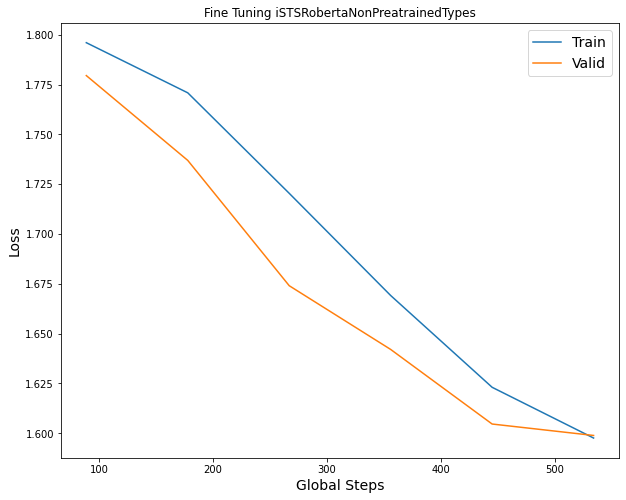

In [ ]:
plt.figure(figsize=(10, 8))
train_loss_list, valid_loss_list, global_steps_list = load_metrics(root + '/'+experiment_name+'_metric.pkl')
plt.plot(global_steps_list, train_loss_list, label='Train')
plt.plot(global_steps_list, valid_loss_list, label='Valid')
plt.xlabel('Global Steps', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.title('Fine Tuning iSTS'+experiment_name)
plt.legend(fontsize=14)
plt.savefig(fname = root + '/'+experiment_name+"pret_fig", format = 'png')
plt.show() 

"Post training" on low learning rate 1e-6

In [ ]:
def classification_report_csv(report, path):
    report_data = []
    lines = report.split('\n')
    
    with open(path, 'w') as f:
      for line in lines:
          f.write(line)
          f.write('\n')



In [ ]:
# Evaluation Function
def evaluate(model, testing_loader, eval_dataset_name = None):
    y_pred = []
    y_true = []

    model.eval()
    with torch.no_grad():
                                        
      for  _,vdata in tqdm(enumerate(testing_loader, 0)):
          vids = vdata['ids'].to(device, dtype = torch.long)
          vmask = vdata['mask'].to(device, dtype = torch.long)
          vtoken_type_ids = vdata['token_type_ids'].to(device, dtype = torch.long)
          vtargets = vdata['targets'].to(device, dtype = torch.long)

          voutputs = model(vids, vmask, vtoken_type_ids)

          y_pred.extend(torch.argmax(voutputs, axis=-1).tolist())
          y_true.extend(vtargets.tolist())
    
    
    print('Classification Report:')
    report = classification_report(y_true, y_pred, labels=list(range(num_outputs)), digits=4)
    print(report)
    classification_report_csv(report, path = root + '/'+experiment_name+"_"+eval_dataset_name+"_report.txt")

    cm = confusion_matrix(y_true, y_pred, labels=list(range(num_outputs)))
    ax = plt.subplot()

    sns.heatmap(cm, annot=True, ax = ax, cmap='Blues', fmt="d")

    ax.set_title('Confusion Matrix')

    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True Labels')

    plt.savefig(fname = root + '/'+experiment_name+"_cm_"+eval_dataset_name, format = 'png')
        
    my_array = np.array([y_pred,y_true])
    df = pd.DataFrame(my_array)
    return df.T



In [ ]:
df_test_headlines = pd.read_csv(semeval2_root+'test_headlines.csv', header= 0)
df_test_imgs = pd.read_csv(semeval2_root+'test_images.csv', header= 0)
df_test_as = pd.read_csv(semeval2_root+'test_answers-students.csv', header= 0)

df_test_headlines = preprocess_semeval(df_test_headlines, is_score_based=is_score_based)
df_test_imgs = preprocess_semeval(df_test_imgs, is_score_based=is_score_based)
df_test_as = preprocess_semeval(df_test_as, is_score_based=is_score_based)


In [ ]:
test_size = df_test_headlines.shape[0] + df_test_imgs.shape[0] + df_test_as.shape[0] 
train_size = df_train.shape[0] 
valid_size =  df_valid.shape[0]

ds_size = test_size + train_size + valid_size

print(ds_size)
print(train_size)
print(train_size)
print(valid_size)
print(test_size)



10048
5663
5663
1416
2969


In [ ]:
MAX_LEN = 256

df_test_headlines = df_test_headlines.reset_index(drop=True)
df_test_imgs = df_test_imgs.reset_index(drop=True)
df_test_as = df_test_as.reset_index(drop=True)


test_headlines_set = Data(df_test_headlines, tokenizer, MAX_LEN)
test_imgs_set = Data(df_test_imgs, tokenizer, MAX_LEN)
test_as_set = Data(df_test_as, tokenizer, MAX_LEN)

In [ ]:
df_test_imgs.head()

,chunk1,chunk2,value,explanation,type,text,target
0,on the tracks,on tracks,5,EQUI,0,on the tracks . on tracks,0
1,Two green and white trains,Two green and white trains,5,EQUI,0,Two green and white trains . Two green and whi...,0
2,in a street,street,5,EQUI,0,in a street . street,0
3,driving,driving down,4,SPE2,3,driving . driving down,3
4,a bus,Red double decker bus,3,SPE2,3,a bus . Red double decker bus,3


In [ ]:
test_params = {'batch_size': 16,
                'shuffle': True,
                'num_workers': 0
                }

headlines_loader = DataLoader(test_headlines_set, **train_params)
imgs_loader = DataLoader(test_imgs_set, **train_params)
as_loader = DataLoader(test_as_set, **train_params)



Ewaulacja Headlines

0it [00:00, ?it/s]/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2336: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
69it [00:13,  5.18it/s]


Classification Report:
              precision    recall  f1-score   support

           0     0.8095    0.9021    0.8533       664
           1     0.4327    0.4933    0.4611       150
           2     0.2909    0.1633    0.2092        98
           3     0.1944    0.1308    0.1564       107
           4     0.4286    0.2727    0.3333        66
           5     0.3333    0.5000    0.4000        10

    accuracy                         0.6630      1095
   macro avg     0.4149    0.4104    0.4022      1095
weighted avg     0.6240    0.6630    0.6383      1095



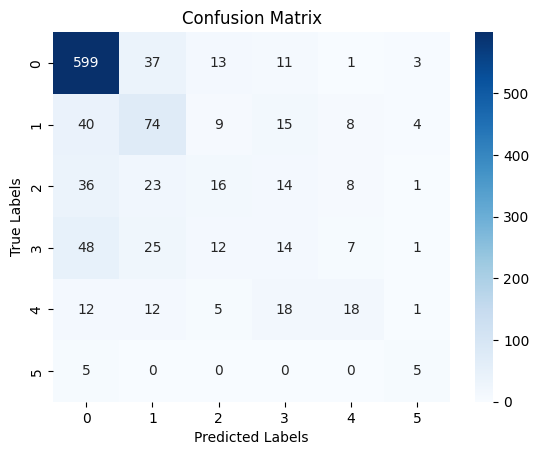

In [ ]:
result_headlines = evaluate(model, headlines_loader, eval_dataset_name ='headlines')


0it [00:00, ?it/s]/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2336: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
59it [00:11,  5.15it/s]


Classification Report:
              precision    recall  f1-score   support

           0     0.7960    0.7976    0.7968       499
           1     0.4648    0.3882    0.4231       170
           2     0.2818    0.4921    0.3584       126
           3     0.2958    0.1927    0.2333       109
           4     0.1667    0.0286    0.0488        35
           5     0.0000    0.0000    0.0000         3

    accuracy                         0.5817       942
   macro avg     0.3342    0.3165    0.3101       942
weighted avg     0.5837    0.5817    0.5752       942



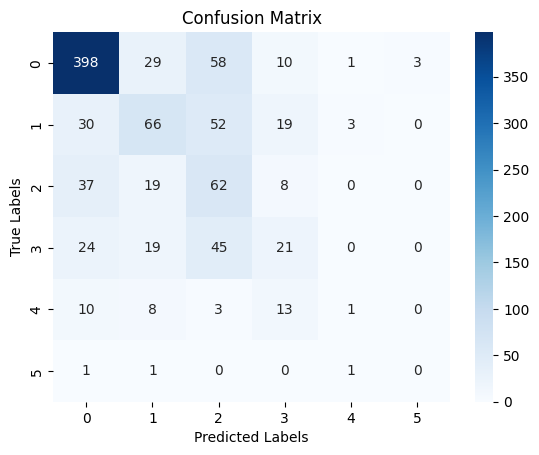

In [ ]:
result_imgs = evaluate(model, imgs_loader, eval_dataset_name ='images')

0it [00:00, ?it/s]/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2336: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
59it [00:11,  5.15it/s]


Classification Report:
              precision    recall  f1-score   support

           0     0.8546    0.6046    0.7082       564
           1     0.7000    0.1818    0.2887        77
           2     0.2439    0.1493    0.1852        67
           3     0.3125    0.3846    0.3448        78
           4     0.5324    0.7629    0.6271        97
           5     0.1857    0.8980    0.3077        49

    accuracy                         0.5504       932
   macro avg     0.4715    0.4969    0.4103       932
weighted avg     0.6839    0.5504    0.5760       932



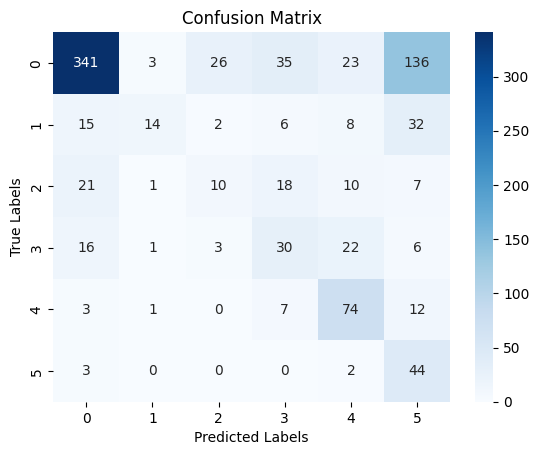

In [ ]:
result_as = evaluate(model, as_loader, eval_dataset_name ='answer_students')

In [ ]:
result_headlines.to_csv(root+ '/'+experiment_name+" headlines.csv", index = False)
result_imgs.to_csv(root+ '/'+experiment_name+" imgs.csv", index = False)
result_as.to_csv(root+ '/'+experiment_name+" as.csv", index = False)